# <a id='toc1_'></a>[UNIT 4. Unsupervised Learning](#toc0_)

This Unit includes main introduction to unsupervised learning, strongly based in {cite:p}`kroese2020`.

**Table of contents**<a id='toc0_'></a>    
- [UNIT 4. Unsupervised Learning](#toc1_)    
  - [EM: Univariate problem](#toc1_1_)    
  - [EM: Multivariate case](#toc1_2_)    
  - [DBSCAN](#toc1_3_)    
  - [Hierarchical clustering](#toc1_4_)    
    - [Agglomerative Hierarchical Clustering](#toc1_4_1_)    
    - [Divisive Hierarchical Clustering](#toc1_4_2_)    
  - [PCA with Singular Value Decomposition](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[EM: Univariate problem](#toc0_)

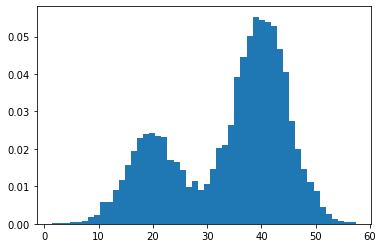

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [1]:
from numpy import hstack
from numpy.random import normal
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
# generate a sample
X1 = normal(loc=20, scale=5, size=3000)
X2 = normal(loc=40, scale=5, size=7000)
X = hstack((X1, X2))
# plot the histogram
plt.hist(X, bins=50, density=True)
plt.show()
# reshape into a table with one column
X = X.reshape((len(X), 1))
# fit model
model = GaussianMixture(n_components=2, init_params='random')
model.fit(X)
yhat = model.predict(X) # predict latent values
print(yhat[:100])       # check latent value for first few points
print(yhat[-100:])      # check latent value for last few points

## <a id='toc1_2_'></a>[EM: Multivariate case](#toc0_)

We will code now a step by step example of the ME algorithm.

We will start by retaking the data in the K-Means experiment used in UNIT 2. Now, we are going to use the Expectation-Maximization (EM) algorithm.

In this exercise, we use 300 data points that were independently generated from three bivariate normal distributiuons with means:

| cluster  | mean vector  | covariance matrix  |
|---|---|---|
| 1 | $\begin{pmatrix}-4\\0\end{pmatrix}$    | $\begin{pmatrix}1&1.4\\1.4&1.5\end{pmatrix}$  |
| 2 | $\begin{pmatrix}0.5\\-1\end{pmatrix}$    |  $\begin{pmatrix}2&-0.95\\-0.95&1\end{pmatrix}$ |
| 3 | $\begin{pmatrix}-1.5\\-3\end{pmatrix}$    | $\begin{pmatrix}2&0.1\\0.1&0.1\end{pmatrix}$  |

<function matplotlib.pyplot.show(close=None, block=None)>

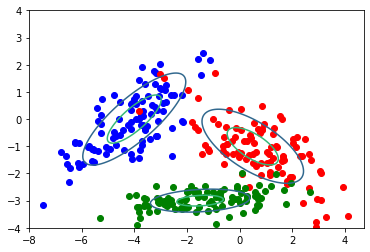

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

#Xmat = np.genfromtxt('datasets/clusterdata.csv', delimiter=',')

mean = []
cov = []
xmat = []


# define the means and covariances of the three pieces of the dataset
mean.append(np.array([-4, 0]))
cov.append(np.array([[2,1.4],[1.4,1.5]]))

mean.append(np.array([0.5, -1]))
cov.append(np.array([[2,-0.95],[-0.95,1]]))

mean.append(np.array([-1.5, -3]))
cov.append(np.array([[2,0.1],[0.1,0.1]]))

c=['b','r','g']
for i in range(3):
    data=np.random.multivariate_normal(mean[i],cov[i],100)
    xmat.append(data)
    plt.scatter(data[:,0],data[:,1],c=c[i])     # plot each sub dataset

Xmat = np.concatenate((xmat[0],xmat[1],xmat[2]),axis=0)

K = 3                   # number of cluster
n, D = Xmat.shape       # dimension of data

# plot the contours of the three Gaussians

for i in range(3):
    N    = 200
    X    = np.linspace(-8, 4, N)
    Y    = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = multivariate_normal(mean[i], cov[i])
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z,levels=2)

plt.show

We will apply the Expectation-Maximization algorithm by introducing auxiliary variables. We use an initial guess of variables $W$

1. The input is the data and an initial guess for the parameters: weights of the Gaussians in the mixture, means and covariances for each
2. We assign the parameters and evaluate $\mu$ and $\mathrm{Cov}$ 
3. We continue iterating until convergence is reached

In [3]:
# convergence is very sensitive to the choce of initial parameters
# so we should try different initial possibilities
W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])  #stores the mu's as columns
C = np.zeros((3,2,2))

# we assume first the covariances in each distribution
C[:,0,0] = 1
C[:,1,1] = 1

p = np.zeros((3,300))
print(p.shape)

for i in range(0,100):      # let us iterate a given number of steps

    for k in range(0,K):    #E-step
        mvn = multivariate_normal( M[:,k].T, C[k,:,:] )
        p[k,:] = W[0,k]*mvn.pdf(Xmat)

    p = p/sum(p,0)   #normalize

    W = np.mean(p,1).reshape(1,3)
    for k in range(0,K):
        M[:,k] = (Xmat.T @ p[k,:].T)/sum(p[k,:])
        xm = Xmat.T - M[:,k].reshape(2,1)
        C[k,:,:] = xm @ (xm*p[k,:]).T/sum(p[k,:])

print(W)
print(M)
print(C)

(3, 300)


[[0.30811885 0.3417826  0.35009855]]
[[-1.54716006 -4.09550252  0.80081707]
 [-2.98874145 -0.04513584 -1.31832856]]
[[[ 2.42875572  0.16570491]
  [ 0.16570491  0.10175855]]

 [[ 1.80454936  1.12889005]
  [ 1.12889005  1.23348418]]

 [[ 1.94232761 -0.7793724 ]
  [-0.7793724   0.96187334]]]


## <a id='toc1_3_'></a>[DBSCAN](#toc0_)

DBSCAN (Density-Based spatial Clustering of Applications with Noise) finds core samples in regions of high density and expands clusters from them. the algorithm works very well for data which contains clusters of similar density.

In the example below we run DBSCAN on the data generated above. In doing so, we realize how data that has not a clear difference in compactness is difficult to clusterize with DBSCAN which, in turn, does a very good job with clearly separated (and grouped) data.

In [4]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

print(Xmat)

db = DBSCAN(eps=1,min_samples=10).fit(Xmat)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present (noisy samples are given the label math: -1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

[[-3.68586805e+00  1.04535095e-01]
 [-3.73786659e+00  1.53294597e-01]
 [-2.80147624e+00  1.26232239e+00]
 [-3.02779398e+00  2.01279903e+00]
 [-4.22684541e+00 -2.20732466e-01]
 [-5.96418668e+00 -1.63515718e+00]
 [-1.10860163e+00  2.17524827e+00]
 [-4.01691267e+00  7.46308389e-01]
 [-4.53620407e+00  6.28668179e-01]
 [-5.38367713e+00 -8.67750023e-02]
 [-5.22043277e+00  7.27783868e-01]
 [-5.72419971e+00 -9.97901082e-01]
 [-2.55420947e+00 -1.37182775e+00]
 [-6.48511859e+00 -2.31082994e+00]
 [-6.26787507e+00 -8.47241155e-01]
 [-4.78859721e+00 -4.82420170e-01]
 [-3.11867989e+00 -6.28632331e-01]
 [-3.32886311e+00  5.06316292e-01]
 [-2.89252952e+00  2.86386198e-01]
 [-6.10360832e+00 -1.77866419e+00]
 [-4.09961779e+00 -1.48557723e+00]
 [-1.38180034e+00  2.43831184e+00]
 [-2.61133615e+00  8.85677323e-01]
 [-3.80580700e+00 -1.43616612e+00]
 [-3.41944309e+00 -7.41444513e-01]
 [-3.36693379e+00  1.93503978e-01]
 [-3.70220394e+00  6.64567259e-01]
 [-3.48622372e+00  8.37020384e-01]
 [-5.27247684e+00 -1

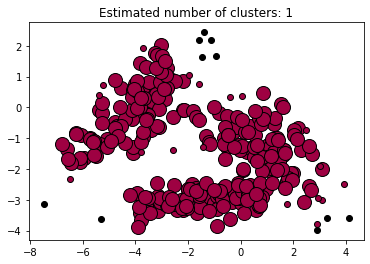

In [5]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Xmat[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = Xmat[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


## <a id='toc1_4_'></a>[Hierarchical clustering](#toc0_)

In hierarchical clustering we use either an agglomerative or divisive algorithm to generate clusters in a given dataset. In this very simple implementation, we use scipy to clusterize a collection of 3 clusters and one single orphan data point. Adapted from [this entry](https://stackoverflow.com/questions/10136470/unsupervised-clustering-with-unknown-number-of-clusters) in Stackoverflow. 

The threshold given as a parameter in the code (`thresh`) is a distance value on which basis the decision is made whether points/clusters will be merged into another cluster. The distance metric being used can also be specified.

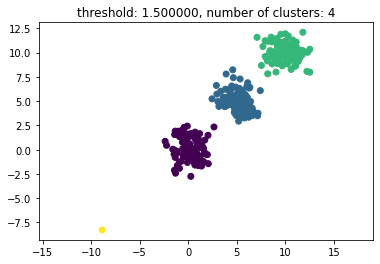

In [6]:
import matplotlib.pyplot as plt
import numpy
import scipy.cluster.hierarchy as hcluster

# generate 3 clusters of each around 100 points and one orphan point
N=100
data = numpy.random.randn(3*N,2)
data[:N] += 5
data[-N:] += 10
data[-1:] -= 20

# clustering
thresh = 1.5
clusters = hcluster.fclusterdata(data, thresh, criterion="distance")

# plotting
plt.scatter(*numpy.transpose(data), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
plt.title(title)
plt.show()

### <a id='toc1_4_1_'></a>[Agglomerative Hierarchical Clustering](#toc0_)

Find below a basic implementation of the Ward linkage function for agglomerative hierarchical clustering, using `scipy` functions. Adapted from {cite:p}`kroese2020`

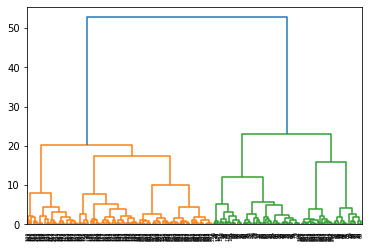

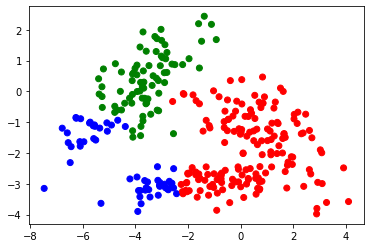

In [7]:
import numpy as np 
from scipy.spatial.distance import cdist

def update_distances(D,i,j, sizes): # calculate distances for merged cluster
    n = D.shape[0]     
    d = np.inf * np.ones(n+1)
    for k in range(n): # Update distances     
       d[k] = ((sizes[i]+sizes[k])*D[i,k] + 
       (sizes[j]+sizes[k])*D[j,k] - 
       sizes[k]*D[i,j])/(sizes[i] + sizes[j] + sizes[k])
                   
    infs =  np.inf * np.ones(n) # array of infinity
    D[i,:],D[:,i],D[j,:],D[:,j] =  infs,infs,infs,infs # deactivate 
    new_D = np.inf * np.ones((n+1,n+1))
    new_D[0:n,0:n] = D # copy old matrix into new_D
    new_D[-1,:], new_D[:,-1] = d,d # add new row and column
    return new_D
            
def agg_cluster(X):  
    n = X.shape[0]
    sizes = np.ones(n)
    D = cdist(X, X,metric = 'sqeuclidean')   # initialize distance matr.
    np.fill_diagonal(D, np.inf * np.ones(D.shape[0]))    
    Z = np.zeros((n-1,4))  #linkage matrix encodes hierachy tree
    for t in range(n-1):
        i,j = np.unravel_index(D.argmin(), D.shape) # minimizer pair
        sizes = np.append(sizes, sizes[i] + sizes[j])
        Z[t,:]=np.array([i, j, np.sqrt(D[i,j]), sizes[-1]]) 
        D = update_distances(D, i,j, sizes)  # update distance matr.
    return Z   
    
# MAIN ROUTINE
import scipy.cluster.hierarchy as h 

#X = np.genfromtxt('clusterdata.csv',delimiter=',') # read the data
Z = agg_cluster(Xmat)  # form the linkage matrix

h.dendrogram(Z) # SciPy can produce a dendogram from Z 
# fcluster function assigns cluster ids to all points based on Z 
cl = h.fcluster(Z, criterion = 'maxclust', t=3) 

import matplotlib.pyplot as plt
plt.figure(2), plt.clf()
cols = ['red','green','blue']
colors = [cols[i-1] for i in cl]
plt.scatter(Xmat[:,0], Xmat[:,1],c=colors)
plt.show()

### <a id='toc1_4_2_'></a>[Divisive Hierarchical Clustering](#toc0_)

and now, for the same data, we aply a divisive clustering approach (also taken from {cite:p}`kroese2020`)

cutvalue  4.89440804758133


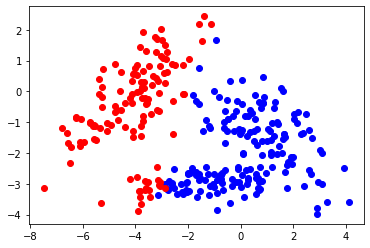

In [8]:
""" clustCE2.py """
import numpy as np
from numpy import genfromtxt
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

def S(x,D):
    V1 = np.where(x==0)[0] # {V1,V2} is the partition 
    V2 = np.where(x==1)[0]
    tmp = D[V1]
    tmp = tmp[:,V2]
    return np.mean(tmp) # the size of the cut

def maxcut(D,N,eps,rho,alpha):
    n = D.shape[1]
    Ne = int(rho*N)
    p = 1/2*np.ones(n) 
    p[0] = 1.0
    while (np.max(np.minimum(p,np.subtract(1,p))) > eps):
        x = np.array(np.random.uniform(0,1, (N,n))<=p, dtype=np.int64)
        sx = np.zeros(N)
        for i in range(N):
            sx[i] = S(x[i],D)
        
        sortSX = np.flip(np.argsort(sx))
        elIds = sortSX[0:Ne]
        elites = x[elIds]
        pnew = np.mean(elites, axis=0)
        p = alpha*pnew + (1.0-alpha)*p

    return np.round(p)

#Xmat = genfromtxt('clusterdata.csv', delimiter=',')
n = Xmat.shape[0]

D = squareform(pdist(Xmat))

N = 1000
eps = 10**-2
rho = 0.1
alpha = 0.9

# CE
pout = maxcut(D,N,eps,rho, alpha);

cutval = S(pout,D)
print("cutvalue ",cutval)
#plot
V1 = np.where(pout==0)[0]
xblue = Xmat[V1]
V2 = np.where(pout==1)[0]
xred = Xmat[V2]
plt.scatter(xblue[:,0],xblue[:,1], c="blue")
plt.scatter(xred[:,0],xred[:,1], c="red")


We will apply HCA to the famous Iris dataset by Fisher. we start by retrieving the data

In [9]:
import requests, zipfile, io

url = "https://archive.ics.uci.edu/static/public/53/iris.zip"
filename = "datasets/iris.data"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("datasets")

# from iris.names
#   1. sepal length in cm
#   2. sepal width in cm
#   3. petal length in cm
#   4. petal width in cm
#   5. class

import pandas as pd
df = pd.read_csv(filename, sep=',',header=None, names=['Sepal.length', 'Sepal.width', 'Petal.length','Petal.width','Species'])
df

,Sepal.length,Sepal.width,Petal.length,Petal.width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


now we build a Scatter Plot Matrix

array([[<AxesSubplot:xlabel='Sepal.length', ylabel='Sepal.length'>,
        <AxesSubplot:xlabel='Sepal.width', ylabel='Sepal.length'>,
        <AxesSubplot:xlabel='Petal.length', ylabel='Sepal.length'>,
        <AxesSubplot:xlabel='Petal.width', ylabel='Sepal.length'>],
       [<AxesSubplot:xlabel='Sepal.length', ylabel='Sepal.width'>,
        <AxesSubplot:xlabel='Sepal.width', ylabel='Sepal.width'>,
        <AxesSubplot:xlabel='Petal.length', ylabel='Sepal.width'>,
        <AxesSubplot:xlabel='Petal.width', ylabel='Sepal.width'>],
       [<AxesSubplot:xlabel='Sepal.length', ylabel='Petal.length'>,
        <AxesSubplot:xlabel='Sepal.width', ylabel='Petal.length'>,
        <AxesSubplot:xlabel='Petal.length', ylabel='Petal.length'>,
        <AxesSubplot:xlabel='Petal.width', ylabel='Petal.length'>],
       [<AxesSubplot:xlabel='Sepal.length', ylabel='Petal.width'>,
        <AxesSubplot:xlabel='Sepal.width', ylabel='Petal.width'>,
        <AxesSubplot:xlabel='Petal.length', ylabel='Petal.

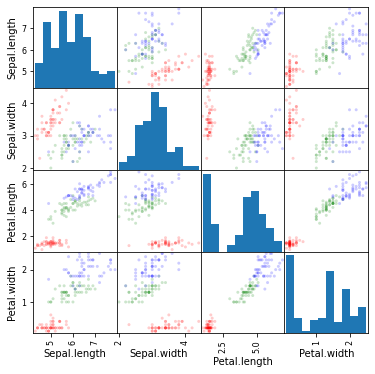

In [10]:
from pandas.plotting import scatter_matrix
import numpy as np
colors= np.array(50*['r']+50*['g']+50*['b'])
scatter_matrix(df,alpha=0.2,figsize=(6,6),grid=True,diagonal='hist',color=colors)

which, in terms of numerical correlation, yields

In [11]:
matrix=df.corr()
print(matrix)

              Sepal.length  Sepal.width  Petal.length  Petal.width
Sepal.length      1.000000    -0.109369      0.871754     0.817954
Sepal.width      -0.109369     1.000000     -0.420516    -0.356544
Petal.length      0.871754    -0.420516      1.000000     0.962757
Petal.width       0.817954    -0.356544      0.962757     1.000000


which can be visualized easily with a heatmap with seaborn:

<AxesSubplot:>

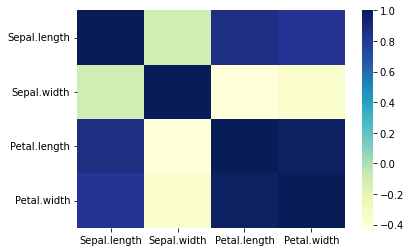

In [12]:
import seaborn as sns
sns.heatmap(matrix,cmap='YlGnBu')

we can also see the diversity of the data using a Parallel Coordinates plot

<AxesSubplot:>

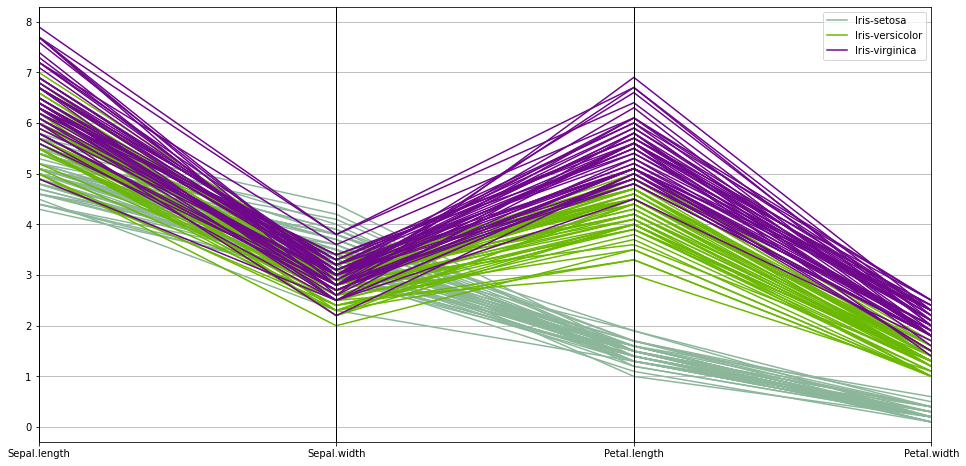

In [13]:
plt.figure(figsize=(16,8))
pd.plotting.parallel_coordinates(df,'Species')

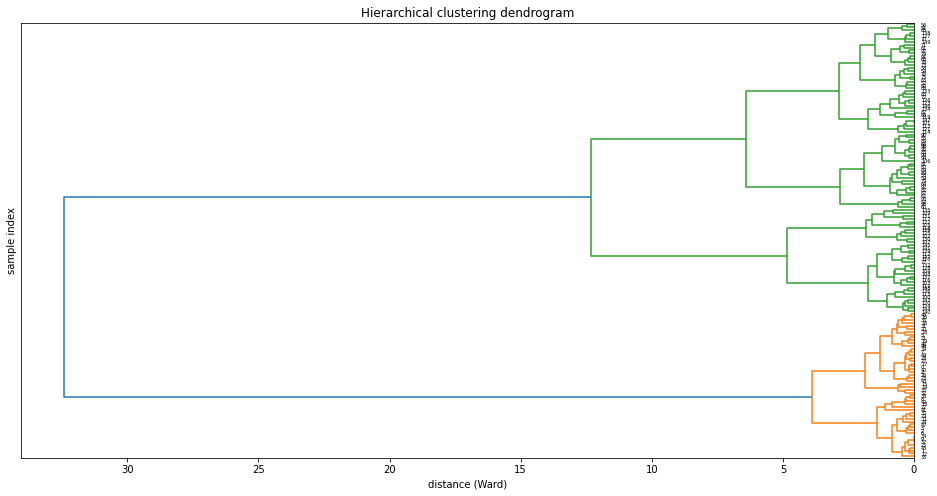

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage


df_dend = df.set_index('Species')
df_dend = df_dend.reset_index(drop=True)
df.head()

Z = linkage(df_dend,'ward')

plt.figure(figsize=(16,8))
plt.title('Hierarchical clustering dendrogram')
plt.ylabel('sample index')
plt.xlabel('distance (Ward)')

dendrogram(Z,labels=df_dend.index,orientation='left')

plt.show()

These visualizations easily demonstrat how the separation of the hierarchical clustering is very good with the “Setosa” species, but misses in labeling many “Versicolor” species as “Virginica”.
Using again seaborn we can mix the HCA with a heatmap:

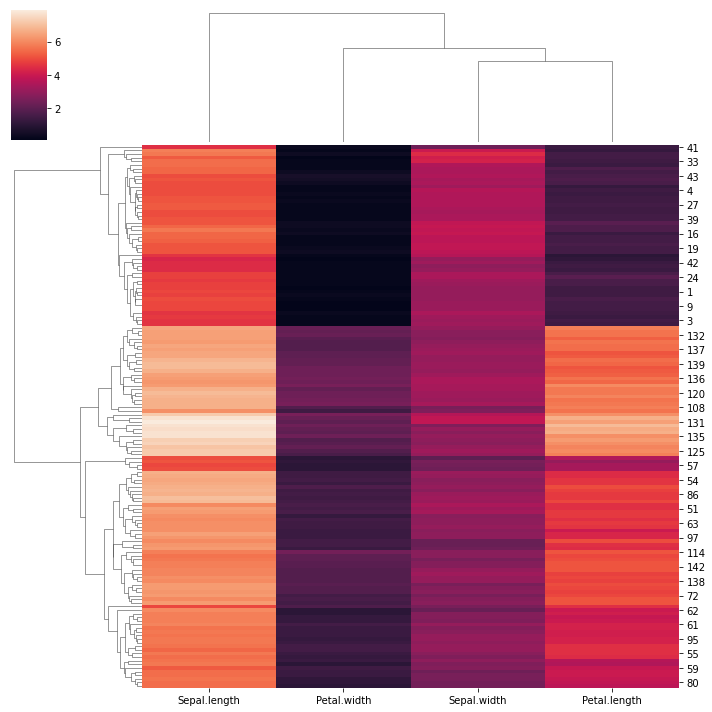

In [15]:
sns.clustermap(df_dend)

Other hierarchical clustering methods are more popular, like [DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html). DBSCAN works well when seeking areas in the data that have a high density of observations, versus areas of the data that are not very dense with observations. DBSCAN can sort data into clusters of varying shapes as well, another strong advantage. 



## <a id='toc1_5_'></a>[PCA with Singular Value Decomposition](#toc0_)

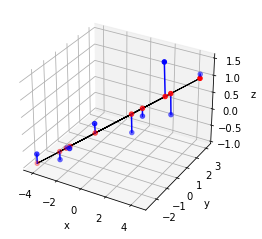

In [16]:
""" PCAdat.py """
import numpy as np 
X = np.genfromtxt('datasets/pcadat.csv', delimiter=',')

n = X.shape[0]

# Gram matrix
X = X - X.mean(axis=0)
G = X.T @ X 
U, _ , _ = np.linalg.svd(G/n)

# projected points first component
Y = X @ np.outer(U[:,0],U[:,0])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.plot(Y[:,0], Y[:,1], Y[:,2], c='k', linewidth=1)
ax.scatter(X[:,0], X[:,1], X[:,2], c='b')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c='r')

for i in range(n):
    ax.plot([X[i,0], Y[i,0]], [X[i,1],Y[i,1]], [X[i,2],Y[i,2]], 'b')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.savefig('../figures/pca1py.pdf')
plt.show()
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

```{bibliography}
:style: unsrt
```